In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.distributions import Normal as norm

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from termcolor import colored

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Process

In [3]:
# trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((50,), (1.0,))])
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1.0,))])

In [4]:
# if not exist, download mnist dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, transform=trans, download=True)
mnist_testset = datasets.MNIST(root='./data', train=False, transform=trans, download=True)

In [5]:
batch_size = 128
N = len(mnist_trainset)
N

60000

In [6]:
N_test = len(mnist_testset)
N_test

10000

In [7]:
train_loader = torch.utils.data.DataLoader(
                 dataset=mnist_trainset,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=mnist_testset,
                batch_size=N_test,
                shuffle=False)

In [8]:
FF = nn.Flatten()

In [9]:
c = 0
for batch_idx, (example_data, example_targets) in enumerate(train_loader):
    c += 1
    print(example_data.shape)
    print(example_targets.shape)
    print("Flatten", FF(example_data).shape)
    if c ==2:   
        break

torch.Size([128, 1, 28, 28])
torch.Size([128])
Flatten torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128])
Flatten torch.Size([128, 784])


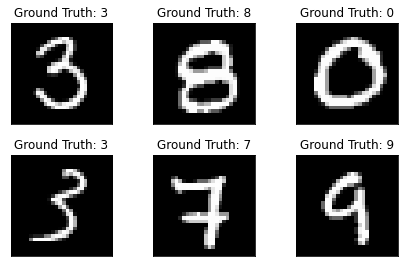

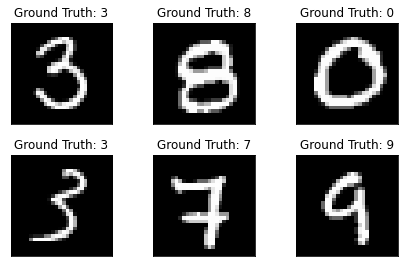

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

# Main functions

In [11]:
class ScaleMixtureGaussian(object):
    def __init__(self, pi, sigma1, sigma2):
        super().__init__()
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.gaussian1 = torch.distributions.Normal(0,sigma1)
        self.gaussian2 = torch.distributions.Normal(0,sigma2)
    
    def log_prob(self, w): #w could be a vector
        prob1 = torch.exp(self.gaussian1.log_prob(w))
        prob2 = torch.exp(self.gaussian2.log_prob(w))
        return (torch.log(self.pi * prob1 + (1-self.pi) * prob2)).sum()

In [12]:
class Gaussian(nn.Module):
    def __init__(self, mu, rho):
        super(Gaussian, self).__init__()
        self.norm   = norm(0,1)
        self.mu_    = mu
        self.rho_   = rho
        self.sigma_ = torch.ones(self.mu_.shape).to(device)
        
        
    def sample(self):
        self.eps    = eps_scale * self.norm.sample(self.mu_.shape).type(self.mu_.type()).to(device)
        self.sigma_ = eps_scale * torch.log(1 + torch.exp(self.rho_)).to(device)
        self.W      = self.mu_  + self.sigma_ * self.eps
        return self.W
    
    def log_prob(self, m, s, w):
        r = torch.log(1 + torch.exp(s))
        return (-np.log(np.sqrt(2 * np.pi)) 
                - 0.5*torch.log(r) 
                - ((w - m) ** 2) / (2 * r)).sum()     
            
    def loss(self):
        return (-0.5 * torch.log(1e-20 + self.sigma_)).sum()

In [13]:
class Blinear(nn.Module):
    def __init__(self, n_input, n_output):
        super(Blinear, self).__init__()
        
        
        self.n_input  = n_input
        self.n_output = n_output
        
        
        self.mu    = nn.Parameter(torch.Tensor(n_output, n_input).normal_(0., .05))  # or .01
        self.rho   = nn.Parameter(torch.Tensor(n_output, n_input).uniform_(-3., -3.))
        
        self.W     = Gaussian(self.mu, self.rho)
        
        self.b_mu  = nn.Parameter(torch.Tensor(n_output).normal_(0., .05))
        self.b_rho = nn.Parameter(torch.Tensor(n_output).uniform_(-3., -3.))
        
        self.b     = Gaussian(self.b_mu, self.b_rho)   
        
        self.log_prior = 0
        self.log_variational_posterior = 0
        
        
        # Prior distributions
        self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_prior   = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_prior    = 0
        self.log_variational_posterior = 0
        
        
    def forward(self, x):
        
        W = self.W.sample()
        b = self.b.sample()
        
        
        self.E_log_prior = self.weight_prior.log_prob(W) + self.bias_prior.log_prob(b)
        self.E_log_variational_posterior = (self.W.log_prob(self.mu, self.rho, W)
                                            + self.b.log_prob(self.b_mu, self.b_rho, b))
        
        return F.linear(x, W, b)

In [14]:
class BNet(nn.Module):
    
    def __init__(self, layers, act):
        super(BNet, self).__init__()
        
        self.act = act
        self.fc  = nn.ModuleList()
        self.flatten = nn.Flatten()
        for i in range(len(layers) - 1):
            self.fc.append(Blinear(layers[i], layers[i+1]))  
            
            
    def forward(self,x):
        x = self.flatten(x)
        for i in range(len(self.fc) - 1):
            x = self.fc[i].forward(x) #forward based on Blinear 
            x = self.act(x)
            
        x = F.log_softmax(self.fc[-1](x), dim=1)
        
        return x
        
        
    def sample_log_prior(self):
        return (self.fc[0].log_prior 
               + self.fc[1].log_prior 
               + self.fc[2].log_prior)
    
    def sample_log_variational_posterior(self):
        return (self.fc[0].log_variational_posterior 
               + self.fc[1].log_variational_posterior 
               + self.fc[2].log_variational_posterior)
    

In [20]:
class BNN():
    def __init__(self, train_loader, layers, act, n_epochs = 10000):
        
        self.train_loader = train_loader
        self.n_layers = len(layers)
        
        self.nepochs = n_epochs
        self.BNet    = BNet(layers, act)
        
        self.History_learning = []
        
    def get_neg_elbo(self):
        Ent = 0
        for i in range(self.n_layers-1):
            Ent += self.BNet.fc[i].W.loss()
            Ent += self.BNet.fc[i].b.loss()

            
        ER1 = self.BNet .sample_log_prior() + self.BNet.sample_log_variational_posterior() + Ent
            
        p_pred = self.BNet(self.x)
        
        return ER1 + N/batch_size * F.nll_loss(p_pred, self.y, reduction='sum') #sum or mean?

        
    
    def train(self, lr, decay, step_size = 1000):
    
        optimizer = torch.optim.Adam(self.BNet.parameters(), lr = lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=decay)
        
        
        with torch.no_grad():
            for _, (example_data, example_targets) in enumerate(test_loader):
                A = example_data/126
                b = example_targets
            z = self.BNet(A).detach()
            T_pred = torch.argmax(z, dim = 1)
            self.History_learning.append((T_pred == b).sum()/len(T_pred))         
        
        
        for n in range(self.nepochs):
            for batch_idx, (example_data, example_targets) in enumerate(train_loader):
                
                self.x = example_data/126
                self.y = example_targets
             
                loss = self.get_neg_elbo()
                if batch_idx %100 == 0:
                    print(n, batch_idx)
                    with torch.no_grad():
                        print("Loss = ", loss.item())
                        acc = 0
                        pl = 0
                        for i in range(100):
                            p_pred = self.BNet(self.x).numpy()
                            y_hat = np.argmax(p_pred, axis = 1)
                            acc += (self.y.numpy() == y_hat).astype(int).mean()
                    
                        print(colored('learning rate:{}'.format(optimizer.param_groups[0]['lr']), 'blue'))
                        print(colored('Train accuracy for iteration {} is {}'.format(n, acc/100), 'red'))
#                         print('Predictive log-likelihood for trainat iteration {} is {}'.format(n, pl/100))
                    
                    
                optimizer.zero_grad()
                loss.backward(retain_graph=True)
                optimizer.step()
                scheduler.step()
                
                
            with torch.no_grad():
                for _, (example_data, example_targets) in enumerate(test_loader):
                    A = example_data/126
                    b = example_targets
                z = self.BNet(A).detach()
                T_pred = torch.argmax(z, dim = 1)
                self.History_learning.append((T_pred == b).sum()/len(T_pred))

In [21]:
eps_scale = 1
PI = 0.25
SIGMA_1 = np.exp(-0)
SIGMA_2 = np.exp(-6)

In [17]:
eps_scale = 1
for lr in [1e-3, 1e-4, 1e-5]:
    for l in [400, 800, 1200]:
        print('---------------------------------------------------------------------')
        print('---------------------------------------------------------------------')
        print(colored("\n\n Start training for lr = {} and hidden_layer size = {}\n\n".format(lr, l), 'green'))
        print('---------------------------------------------------------------------')
        print('---------------------------------------------------------------------')
        model1 = BNN(train_loader, [784, l, l, 10], act = nn.ReLU(), n_epochs = 30)
        model1.train(lr = lr, decay = 1)
#         models.append(model)
        print('---------------------------------------------------------------------')
        print('---------------------------------------------------------------------')
    
        for _, (example_data, example_targets) in enumerate(test_loader):
            A = example_data/126
            b = example_targets
        z = model1.BNet(A).detach()
        T_pred = torch.argmax(z, dim = 1)
        print((T_pred == b).sum()/len(T_pred))

---------------------------------------------------------------------
---------------------------------------------------------------------


 Start training for lr = 0.001 and hidden_layer size = 400


---------------------------------------------------------------------
---------------------------------------------------------------------
0 0
Loss =  138303.515625
learning rate:0.001
Train accuracy for iteration 0 is 0.099765625
0 100
Loss =  835330.1875
learning rate:0.001
Train accuracy for iteration 0 is 0.292265625
0 200
Loss =  749926.75
learning rate:0.001
Train accuracy for iteration 0 is 0.64484375
0 300
Loss =  720675.9375
learning rate:0.001
Train accuracy for iteration 0 is 0.725234375
0 400
Loss =  683628.0625
learning rate:0.001
Train accuracy for iteration 0 is 0.808046875
1 0
Loss =  663335.6875
learning rate:0.001
Train accuracy for iteration 1 is 0.8559375
1 100
Loss =  656084.25
learning rate:0.001
Train accuracy for iteration 1 is 0.808046875
1 200
Loss =  631956.6

14 200
Loss =  69069.9140625
learning rate:0.001
Train accuracy for iteration 14 is 0.964140625
14 300
Loss =  72803.4140625
learning rate:0.001
Train accuracy for iteration 14 is 0.943359375
14 400
Loss =  63678.85546875
learning rate:0.001
Train accuracy for iteration 14 is 0.948203125
15 0
Loss =  58627.4296875
learning rate:0.001
Train accuracy for iteration 15 is 0.951875
15 100
Loss =  53345.796875
learning rate:0.001
Train accuracy for iteration 15 is 0.960234375
15 200
Loss =  55599.90234375
learning rate:0.001
Train accuracy for iteration 15 is 0.945625
15 300
Loss =  54599.78125
learning rate:0.001
Train accuracy for iteration 15 is 0.945078125
15 400
Loss =  45460.4765625
learning rate:0.001
Train accuracy for iteration 15 is 0.927890625
16 0
Loss =  39064.1875
learning rate:0.001
Train accuracy for iteration 16 is 0.969609375
16 100
Loss =  35997.3515625
learning rate:0.001
Train accuracy for iteration 16 is 0.9675
16 200
Loss =  36735.55078125
learning rate:0.001
Train acc

29 0
Loss =  -115375.3828125
learning rate:0.001
Train accuracy for iteration 29 is 0.9684375
29 100
Loss =  -113881.6640625
learning rate:0.001
Train accuracy for iteration 29 is 0.95421875
29 200
Loss =  -115762.4609375
learning rate:0.001
Train accuracy for iteration 29 is 0.980546875
29 300
Loss =  -114069.1640625
learning rate:0.001
Train accuracy for iteration 29 is 0.95875
29 400
Loss =  -116692.890625
learning rate:0.001
Train accuracy for iteration 29 is 0.950546875
---------------------------------------------------------------------
---------------------------------------------------------------------
tensor(0.9576)
---------------------------------------------------------------------
---------------------------------------------------------------------


 Start training for lr = 0.001 and hidden_layer size = 800


---------------------------------------------------------------------
---------------------------------------------------------------------
0 0
Loss =  140158.156

13 100
Loss =  159355.1875
learning rate:0.001
Train accuracy for iteration 13 is 0.94625
13 200
Loss =  151988.5625
learning rate:0.001
Train accuracy for iteration 13 is 0.921875
13 300
Loss =  127129.1484375
learning rate:0.001
Train accuracy for iteration 13 is 0.97859375
13 400
Loss =  117702.015625
learning rate:0.001
Train accuracy for iteration 13 is 0.957265625
14 0
Loss =  107654.8984375
learning rate:0.001
Train accuracy for iteration 14 is 0.963203125
14 100
Loss =  93086.5234375
learning rate:0.001
Train accuracy for iteration 14 is 0.9728125
14 200
Loss =  84937.2890625
learning rate:0.001
Train accuracy for iteration 14 is 0.94890625
14 300
Loss =  81536.8359375
learning rate:0.001
Train accuracy for iteration 14 is 0.9396875
14 400
Loss =  66199.265625
learning rate:0.001
Train accuracy for iteration 14 is 0.94046875
15 0
Loss =  54594.1953125
learning rate:0.001
Train accuracy for iteration 15 is 0.9553125
15 100
Loss =  46270.8359375
learning rate:0.001
Train accuracy

27 400
Loss =  -411046.21875
learning rate:0.001
Train accuracy for iteration 27 is 0.96171875
28 0
Loss =  -417927.59375
learning rate:0.001
Train accuracy for iteration 28 is 0.974296875
28 100
Loss =  -421746.375
learning rate:0.001
Train accuracy for iteration 28 is 0.976953125
28 200
Loss =  -428129.71875
learning rate:0.001
Train accuracy for iteration 28 is 0.95625
28 300
Loss =  -424691.46875
learning rate:0.001
Train accuracy for iteration 28 is 0.938359375
28 400
Loss =  -440114.6875
learning rate:0.001
Train accuracy for iteration 28 is 0.959453125
29 0
Loss =  -435079.375
learning rate:0.001
Train accuracy for iteration 29 is 0.931953125
29 100
Loss =  -438488.4375
learning rate:0.001
Train accuracy for iteration 29 is 0.946171875
29 200
Loss =  -454813.53125
learning rate:0.001
Train accuracy for iteration 29 is 0.957734375
29 300
Loss =  -455342.125
learning rate:0.001
Train accuracy for iteration 29 is 0.949296875
29 400
Loss =  -465607.625
learning rate:0.001
Train accu

12 0
Loss =  343549.8125
learning rate:0.001
Train accuracy for iteration 12 is 0.9265625
12 100
Loss =  318606.875
learning rate:0.001
Train accuracy for iteration 12 is 0.9359375
12 200
Loss =  287485.9375
learning rate:0.001
Train accuracy for iteration 12 is 0.935
12 300
Loss =  262194.0
learning rate:0.001
Train accuracy for iteration 12 is 0.943203125
12 400
Loss =  238085.65625
learning rate:0.001
Train accuracy for iteration 12 is 0.916953125
13 0
Loss =  218198.234375
learning rate:0.001
Train accuracy for iteration 13 is 0.90921875
13 100
Loss =  190790.296875
learning rate:0.001
Train accuracy for iteration 13 is 0.932734375
13 200
Loss =  161620.53125
learning rate:0.001
Train accuracy for iteration 13 is 0.9484375
13 300
Loss =  138149.21875
learning rate:0.001
Train accuracy for iteration 13 is 0.946875
13 400
Loss =  123279.140625
learning rate:0.001
Train accuracy for iteration 13 is 0.916796875
14 0
Loss =  94821.859375
learning rate:0.001
Train accuracy for iteration 

26 400
Loss =  -881750.1875
learning rate:0.001
Train accuracy for iteration 26 is 0.933046875
27 0
Loss =  -889405.25
learning rate:0.001
Train accuracy for iteration 27 is 0.94484375
27 100
Loss =  -897240.0625
learning rate:0.001
Train accuracy for iteration 27 is 0.93609375
27 200
Loss =  -912189.875
learning rate:0.001
Train accuracy for iteration 27 is 0.956328125
27 300
Loss =  -930051.9375
learning rate:0.001
Train accuracy for iteration 27 is 0.973671875
27 400
Loss =  -941719.8125
learning rate:0.001
Train accuracy for iteration 27 is 0.961171875
28 0
Loss =  -949220.0
learning rate:0.001
Train accuracy for iteration 28 is 0.96796875
28 100
Loss =  -956564.0
learning rate:0.001
Train accuracy for iteration 28 is 0.949453125
28 200
Loss =  -971287.25
learning rate:0.001
Train accuracy for iteration 28 is 0.969375
28 300
Loss =  -976118.4375
learning rate:0.001
Train accuracy for iteration 28 is 0.926484375
28 400
Loss =  -994562.1875
learning rate:0.001
Train accuracy for iter

learning rate:0.0001
Train accuracy for iteration 10 is 0.842265625
11 0
Loss =  665298.0625
learning rate:0.0001
Train accuracy for iteration 11 is 0.843046875
11 100
Loss =  664027.5
learning rate:0.0001
Train accuracy for iteration 11 is 0.849453125
11 200
Loss =  652897.0625
learning rate:0.0001
Train accuracy for iteration 11 is 0.898046875
11 300
Loss =  664801.0625
learning rate:0.0001
Train accuracy for iteration 11 is 0.820078125
11 400
Loss =  663891.1875
learning rate:0.0001
Train accuracy for iteration 11 is 0.848125
12 0
Loss =  653934.3125
learning rate:0.0001
Train accuracy for iteration 12 is 0.857421875
12 100
Loss =  652273.375
learning rate:0.0001
Train accuracy for iteration 12 is 0.85328125
12 200
Loss =  673050.3125
learning rate:0.0001
Train accuracy for iteration 12 is 0.771796875
12 300
Loss =  655810.8125
learning rate:0.0001
Train accuracy for iteration 12 is 0.838125
12 400
Loss =  645918.5625
learning rate:0.0001
Train accuracy for iteration 12 is 0.8546093

learning rate:0.0001
Train accuracy for iteration 25 is 0.923359375
25 400
Loss =  556446.0
learning rate:0.0001
Train accuracy for iteration 25 is 0.908359375
26 0
Loss =  566147.75
learning rate:0.0001
Train accuracy for iteration 26 is 0.9021875
26 100
Loss =  559514.875
learning rate:0.0001
Train accuracy for iteration 26 is 0.869453125
26 200
Loss =  553709.9375
learning rate:0.0001
Train accuracy for iteration 26 is 0.922109375
26 300
Loss =  559061.4375
learning rate:0.0001
Train accuracy for iteration 26 is 0.864453125
26 400
Loss =  548478.125
learning rate:0.0001
Train accuracy for iteration 26 is 0.902734375
27 0
Loss =  556793.125
learning rate:0.0001
Train accuracy for iteration 27 is 0.868515625
27 100
Loss =  547285.0625
learning rate:0.0001
Train accuracy for iteration 27 is 0.910234375
27 200
Loss =  560075.8125
learning rate:0.0001
Train accuracy for iteration 27 is 0.85734375
27 300
Loss =  545379.4375
learning rate:0.0001
Train accuracy for iteration 27 is 0.8696093

9 400
Loss =  1760771.875
learning rate:0.0001
Train accuracy for iteration 9 is 0.88546875
10 0
Loss =  1752813.75
learning rate:0.0001
Train accuracy for iteration 10 is 0.850625
10 100
Loss =  1757573.625
learning rate:0.0001
Train accuracy for iteration 10 is 0.86296875
10 200
Loss =  1753551.0
learning rate:0.0001
Train accuracy for iteration 10 is 0.830234375
10 300
Loss =  1750102.5
learning rate:0.0001
Train accuracy for iteration 10 is 0.8409375
10 400
Loss =  1739498.375
learning rate:0.0001
Train accuracy for iteration 10 is 0.855546875
11 0
Loss =  1734013.375
learning rate:0.0001
Train accuracy for iteration 11 is 0.885078125
11 100
Loss =  1728708.875
learning rate:0.0001
Train accuracy for iteration 11 is 0.872890625
11 200
Loss =  1724716.5
learning rate:0.0001
Train accuracy for iteration 11 is 0.8803125
11 300
Loss =  1730051.375
learning rate:0.0001
Train accuracy for iteration 11 is 0.9115625
11 400
Loss =  1717571.25
learning rate:0.0001
Train accuracy for iteratio

24 300
Loss =  1489881.875
learning rate:0.0001
Train accuracy for iteration 24 is 0.897734375
24 400
Loss =  1484209.75
learning rate:0.0001
Train accuracy for iteration 24 is 0.886015625
25 0
Loss =  1497435.5
learning rate:0.0001
Train accuracy for iteration 25 is 0.841484375
25 100
Loss =  1478054.25
learning rate:0.0001
Train accuracy for iteration 25 is 0.9090625
25 200
Loss =  1472178.375
learning rate:0.0001
Train accuracy for iteration 25 is 0.914140625
25 300
Loss =  1476038.25
learning rate:0.0001
Train accuracy for iteration 25 is 0.909609375
25 400
Loss =  1472776.625
learning rate:0.0001
Train accuracy for iteration 25 is 0.8846875
26 0
Loss =  1466666.375
learning rate:0.0001
Train accuracy for iteration 26 is 0.914765625
26 100
Loss =  1465953.25
learning rate:0.0001
Train accuracy for iteration 26 is 0.892890625
26 200
Loss =  1474233.375
learning rate:0.0001
Train accuracy for iteration 26 is 0.8428125
26 300
Loss =  1464589.25
learning rate:0.0001
Train accuracy for 

8 400
Loss =  3316952.25
learning rate:0.0001
Train accuracy for iteration 8 is 0.886875
9 0
Loss =  3311608.5
learning rate:0.0001
Train accuracy for iteration 9 is 0.85921875
9 100
Loss =  3306038.75
learning rate:0.0001
Train accuracy for iteration 9 is 0.84796875
9 200
Loss =  3317707.25
learning rate:0.0001
Train accuracy for iteration 9 is 0.821015625
9 300
Loss =  3295604.25
learning rate:0.0001
Train accuracy for iteration 9 is 0.8359375
9 400
Loss =  3290729.75
learning rate:0.0001
Train accuracy for iteration 9 is 0.851328125
10 0
Loss =  3277910.25
learning rate:0.0001
Train accuracy for iteration 10 is 0.843125
10 100
Loss =  3268688.75
learning rate:0.0001
Train accuracy for iteration 10 is 0.857421875
10 200
Loss =  3264756.75
learning rate:0.0001
Train accuracy for iteration 10 is 0.86671875
10 300
Loss =  3270767.5
learning rate:0.0001
Train accuracy for iteration 10 is 0.80921875
10 400
Loss =  3249951.0
learning rate:0.0001
Train accuracy for iteration 10 is 0.8832812

23 400
Loss =  2803837.75
learning rate:0.0001
Train accuracy for iteration 23 is 0.86765625
24 0
Loss =  2794149.75
learning rate:0.0001
Train accuracy for iteration 24 is 0.899375
24 100
Loss =  2794344.5
learning rate:0.0001
Train accuracy for iteration 24 is 0.855546875
24 200
Loss =  2788821.5
learning rate:0.0001
Train accuracy for iteration 24 is 0.900390625
24 300
Loss =  2772914.75
learning rate:0.0001
Train accuracy for iteration 24 is 0.89390625
24 400
Loss =  2764280.5
learning rate:0.0001
Train accuracy for iteration 24 is 0.911640625
25 0
Loss =  2771726.75
learning rate:0.0001
Train accuracy for iteration 25 is 0.8646875
25 100
Loss =  2755556.5
learning rate:0.0001
Train accuracy for iteration 25 is 0.91171875
25 200
Loss =  2745479.0
learning rate:0.0001
Train accuracy for iteration 25 is 0.9071875
25 300
Loss =  2747549.75
learning rate:0.0001
Train accuracy for iteration 25 is 0.874765625
25 400
Loss =  2732702.5
learning rate:0.0001
Train accuracy for iteration 25 i

8 0
Loss =  853328.5625
learning rate:1e-05
Train accuracy for iteration 8 is 0.13015625
8 100
Loss =  853648.625
learning rate:1e-05
Train accuracy for iteration 8 is 0.121171875
8 200
Loss =  852570.0625
learning rate:1e-05
Train accuracy for iteration 8 is 0.14125
8 300
Loss =  852580.0
learning rate:1e-05
Train accuracy for iteration 8 is 0.140703125
8 400
Loss =  852105.75
learning rate:1e-05
Train accuracy for iteration 8 is 0.144375
9 0
Loss =  852981.25
learning rate:1e-05
Train accuracy for iteration 9 is 0.134921875
9 100
Loss =  851825.8125
learning rate:1e-05
Train accuracy for iteration 9 is 0.137109375
9 200
Loss =  850757.25
learning rate:1e-05
Train accuracy for iteration 9 is 0.132265625
9 300
Loss =  850459.4375
learning rate:1e-05
Train accuracy for iteration 9 is 0.1615625
9 400
Loss =  851384.125
learning rate:1e-05
Train accuracy for iteration 9 is 0.127421875
10 0
Loss =  851295.125
learning rate:1e-05
Train accuracy for iteration 10 is 0.13953125
10 100
Loss =  

23 0
Loss =  821353.25
learning rate:1e-05
Train accuracy for iteration 23 is 0.4071875
23 100
Loss =  823681.25
learning rate:1e-05
Train accuracy for iteration 23 is 0.38875
23 200
Loss =  824064.875
learning rate:1e-05
Train accuracy for iteration 23 is 0.376953125
23 300
Loss =  819821.4375
learning rate:1e-05
Train accuracy for iteration 23 is 0.40765625
23 400
Loss =  823431.75
learning rate:1e-05
Train accuracy for iteration 23 is 0.382265625
24 0
Loss =  821239.625
learning rate:1e-05
Train accuracy for iteration 24 is 0.3815625
24 100
Loss =  819722.8125
learning rate:1e-05
Train accuracy for iteration 24 is 0.399375
24 200
Loss =  822644.375
learning rate:1e-05
Train accuracy for iteration 24 is 0.4015625
24 300
Loss =  819582.0
learning rate:1e-05
Train accuracy for iteration 24 is 0.36421875
24 400
Loss =  817877.875
learning rate:1e-05
Train accuracy for iteration 24 is 0.4115625
25 0
Loss =  818379.375
learning rate:1e-05
Train accuracy for iteration 25 is 0.41125
25 100


7 100
Loss =  2049464.125
learning rate:1e-05
Train accuracy for iteration 7 is 0.15359375
7 200
Loss =  2051342.125
learning rate:1e-05
Train accuracy for iteration 7 is 0.155546875
7 300
Loss =  2048690.125
learning rate:1e-05
Train accuracy for iteration 7 is 0.14734375
7 400
Loss =  2047840.625
learning rate:1e-05
Train accuracy for iteration 7 is 0.1653125
8 0
Loss =  2047662.5
learning rate:1e-05
Train accuracy for iteration 8 is 0.13734375
8 100
Loss =  2045435.75
learning rate:1e-05
Train accuracy for iteration 8 is 0.16328125
8 200
Loss =  2046453.875
learning rate:1e-05
Train accuracy for iteration 8 is 0.158125
8 300
Loss =  2045649.0
learning rate:1e-05
Train accuracy for iteration 8 is 0.144375
8 400
Loss =  2045751.5
learning rate:1e-05
Train accuracy for iteration 8 is 0.175703125
9 0
Loss =  2044952.375
learning rate:1e-05
Train accuracy for iteration 9 is 0.1646875
9 100
Loss =  2045013.25
learning rate:1e-05
Train accuracy for iteration 9 is 0.152421875
9 200
Loss =  

22 100
Loss =  1977986.5
learning rate:1e-05
Train accuracy for iteration 22 is 0.4990625
22 200
Loss =  1975667.875
learning rate:1e-05
Train accuracy for iteration 22 is 0.506015625
22 300
Loss =  1977935.625
learning rate:1e-05
Train accuracy for iteration 22 is 0.47078125
22 400
Loss =  1975130.75
learning rate:1e-05
Train accuracy for iteration 22 is 0.518359375
23 0
Loss =  1975412.25
learning rate:1e-05
Train accuracy for iteration 23 is 0.496484375
23 100
Loss =  1981733.75
learning rate:1e-05
Train accuracy for iteration 23 is 0.445390625
23 200
Loss =  1975370.0
learning rate:1e-05
Train accuracy for iteration 23 is 0.47625
23 300
Loss =  1975747.125
learning rate:1e-05
Train accuracy for iteration 23 is 0.4996875
23 400
Loss =  1977327.75
learning rate:1e-05
Train accuracy for iteration 23 is 0.49453125
24 0
Loss =  1973476.875
learning rate:1e-05
Train accuracy for iteration 24 is 0.514375
24 100
Loss =  1964112.25
learning rate:1e-05
Train accuracy for iteration 24 is 0.60

6 200
Loss =  3729183.75
learning rate:1e-05
Train accuracy for iteration 6 is 0.147578125
6 300
Loss =  3729405.25
learning rate:1e-05
Train accuracy for iteration 6 is 0.162578125
6 400
Loss =  3725601.25
learning rate:1e-05
Train accuracy for iteration 6 is 0.1703125
7 0
Loss =  3728317.75
learning rate:1e-05
Train accuracy for iteration 7 is 0.149609375
7 100
Loss =  3726330.5
learning rate:1e-05
Train accuracy for iteration 7 is 0.175234375
7 200
Loss =  3725197.0
learning rate:1e-05
Train accuracy for iteration 7 is 0.161640625
7 300
Loss =  3723522.5
learning rate:1e-05
Train accuracy for iteration 7 is 0.1640625
7 400
Loss =  3722745.25
learning rate:1e-05
Train accuracy for iteration 7 is 0.19484375
8 0
Loss =  3720107.5
learning rate:1e-05
Train accuracy for iteration 8 is 0.19
8 100
Loss =  3721092.25
learning rate:1e-05
Train accuracy for iteration 8 is 0.16546875
8 200
Loss =  3719031.25
learning rate:1e-05
Train accuracy for iteration 8 is 0.1890625
8 300
Loss =  3718560.

21 300
Loss =  3635337.0
learning rate:1e-05
Train accuracy for iteration 21 is 0.475390625
21 400
Loss =  3629693.25
learning rate:1e-05
Train accuracy for iteration 21 is 0.5053125
22 0
Loss =  3622846.25
learning rate:1e-05
Train accuracy for iteration 22 is 0.576328125
22 100
Loss =  3620606.5
learning rate:1e-05
Train accuracy for iteration 22 is 0.540234375
22 200
Loss =  3617780.75
learning rate:1e-05
Train accuracy for iteration 22 is 0.503203125
22 300
Loss =  3614120.5
learning rate:1e-05
Train accuracy for iteration 22 is 0.56125
22 400
Loss =  3616291.5
learning rate:1e-05
Train accuracy for iteration 22 is 0.500703125
23 0
Loss =  3617324.25
learning rate:1e-05
Train accuracy for iteration 23 is 0.520078125
23 100
Loss =  3602857.25
learning rate:1e-05
Train accuracy for iteration 23 is 0.62890625
23 200
Loss =  3609457.0
learning rate:1e-05
Train accuracy for iteration 23 is 0.518203125
23 300
Loss =  3616514.75
learning rate:1e-05
Train accuracy for iteration 23 is 0.523

In [18]:
eps_scale = 1
for lr in [1e-3, 1e-4, 1e-5]:
    for l in [400, 800, 1200]:
        print('---------------------------------------------------------------------')
        print('---------------------------------------------------------------------')
        print(colored("\n\n Start training for lr = {} and hidden_layer size = {}\n\n".format(lr, l), 'green'))
        print('---------------------------------------------------------------------')
        print('---------------------------------------------------------------------')
        model2 = BNN(train_loader, [784, l, l, 10], act = nn.Tanh(), n_epochs = 30)
        model2.train(lr = lr, decay = 1)
        #models.append(model)
        print('---------------------------------------------------------------------')
        print('---------------------------------------------------------------------')
    
        for _, (example_data, example_targets) in enumerate(test_loader):
            A = example_data/126
            b = example_targets
        z = model2.BNet(A).detach()
        T_pred = torch.argmax(z, dim = 1)
        print((T_pred == b).sum()/len(T_pred))

---------------------------------------------------------------------
---------------------------------------------------------------------


 Start training for lr = 0.001 and hidden_layer size = 400


---------------------------------------------------------------------
---------------------------------------------------------------------
0 0
Loss =  139292.265625
learning rate:0.001
Train accuracy for iteration 0 is 0.098359375
0 100
Loss =  803035.1875
learning rate:0.001
Train accuracy for iteration 0 is 0.471328125
0 200
Loss =  735177.9375
learning rate:0.001
Train accuracy for iteration 0 is 0.769765625
0 300
Loss =  715255.375
learning rate:0.001
Train accuracy for iteration 0 is 0.807734375
0 400
Loss =  693771.0625
learning rate:0.001
Train accuracy for iteration 0 is 0.858359375
1 0
Loss =  679230.0
learning rate:0.001
Train accuracy for iteration 1 is 0.85765625
1 100
Loss =  654396.8125
learning rate:0.001
Train accuracy for iteration 1 is 0.864375
1 200
Loss =  640295.62

14 200
Loss =  126055.015625
learning rate:0.001
Train accuracy for iteration 14 is 0.9028125
14 300
Loss =  119967.2265625
learning rate:0.001
Train accuracy for iteration 14 is 0.9121875
14 400
Loss =  117187.9375
learning rate:0.001
Train accuracy for iteration 14 is 0.927109375
15 0
Loss =  114498.5
learning rate:0.001
Train accuracy for iteration 15 is 0.924609375
15 100
Loss =  110386.6875
learning rate:0.001
Train accuracy for iteration 15 is 0.928203125
15 200
Loss =  105142.1328125
learning rate:0.001
Train accuracy for iteration 15 is 0.920546875
15 300
Loss =  100887.71875
learning rate:0.001
Train accuracy for iteration 15 is 0.910625
15 400
Loss =  98978.5390625
learning rate:0.001
Train accuracy for iteration 15 is 0.9384375
16 0
Loss =  106493.5
learning rate:0.001
Train accuracy for iteration 16 is 0.894453125
16 100
Loss =  96881.015625
learning rate:0.001
Train accuracy for iteration 16 is 0.92046875
16 200
Loss =  98877.453125
learning rate:0.001
Train accuracy for i

29 0
Loss =  -51463.80078125
learning rate:0.001
Train accuracy for iteration 29 is 0.917421875
29 100
Loss =  -60592.5234375
learning rate:0.001
Train accuracy for iteration 29 is 0.9590625
29 200
Loss =  -53075.19140625
learning rate:0.001
Train accuracy for iteration 29 is 0.923359375
29 300
Loss =  -55991.76171875
learning rate:0.001
Train accuracy for iteration 29 is 0.930859375
29 400
Loss =  -61566.64453125
learning rate:0.001
Train accuracy for iteration 29 is 0.948515625
---------------------------------------------------------------------
---------------------------------------------------------------------
tensor(0.9359)
---------------------------------------------------------------------
---------------------------------------------------------------------


 Start training for lr = 0.001 and hidden_layer size = 800


---------------------------------------------------------------------
---------------------------------------------------------------------
0 0
Loss =  14021

13 100
Loss =  431404.25
learning rate:0.001
Train accuracy for iteration 13 is 0.931953125
13 200
Loss =  422664.15625
learning rate:0.001
Train accuracy for iteration 13 is 0.906640625
13 300
Loss =  421148.9375
learning rate:0.001
Train accuracy for iteration 13 is 0.906171875
13 400
Loss =  418737.21875
learning rate:0.001
Train accuracy for iteration 13 is 0.899375
14 0
Loss =  397634.1875
learning rate:0.001
Train accuracy for iteration 14 is 0.908671875
14 100
Loss =  390107.28125
learning rate:0.001
Train accuracy for iteration 14 is 0.885625
14 200
Loss =  391530.5625
learning rate:0.001
Train accuracy for iteration 14 is 0.903046875
14 300
Loss =  370750.46875
learning rate:0.001
Train accuracy for iteration 14 is 0.913671875
14 400
Loss =  351888.15625
learning rate:0.001
Train accuracy for iteration 14 is 0.917265625
15 0
Loss =  352919.03125
learning rate:0.001
Train accuracy for iteration 15 is 0.90921875
15 100
Loss =  330932.0
learning rate:0.001
Train accuracy for iter

28 0
Loss =  -53359.296875
learning rate:0.001
Train accuracy for iteration 28 is 0.92578125
28 100
Loss =  -61818.53125
learning rate:0.001
Train accuracy for iteration 28 is 0.898515625
28 200
Loss =  -72617.71875
learning rate:0.001
Train accuracy for iteration 28 is 0.936171875
28 300
Loss =  -79695.578125
learning rate:0.001
Train accuracy for iteration 28 is 0.92546875
28 400
Loss =  -69536.234375
learning rate:0.001
Train accuracy for iteration 28 is 0.896953125
29 0
Loss =  -85418.1328125
learning rate:0.001
Train accuracy for iteration 29 is 0.915546875
29 100
Loss =  -80664.390625
learning rate:0.001
Train accuracy for iteration 29 is 0.91828125
29 200
Loss =  -93738.203125
learning rate:0.001
Train accuracy for iteration 29 is 0.927890625
29 300
Loss =  -101542.3828125
learning rate:0.001
Train accuracy for iteration 29 is 0.927890625
29 400
Loss =  -96256.9765625
learning rate:0.001
Train accuracy for iteration 29 is 0.91640625
----------------------------------------------

12 100
Loss =  1049163.25
learning rate:0.001
Train accuracy for iteration 12 is 0.90703125
12 200
Loss =  1053468.625
learning rate:0.001
Train accuracy for iteration 12 is 0.881328125
12 300
Loss =  1014190.5625
learning rate:0.001
Train accuracy for iteration 12 is 0.888125
12 400
Loss =  994673.125
learning rate:0.001
Train accuracy for iteration 12 is 0.886484375
13 0
Loss =  961812.6875
learning rate:0.001
Train accuracy for iteration 13 is 0.930703125
13 100
Loss =  948166.6875
learning rate:0.001
Train accuracy for iteration 13 is 0.9009375
13 200
Loss =  939507.4375
learning rate:0.001
Train accuracy for iteration 13 is 0.85828125
13 300
Loss =  910857.125
learning rate:0.001
Train accuracy for iteration 13 is 0.87921875
13 400
Loss =  890158.1875
learning rate:0.001
Train accuracy for iteration 13 is 0.915078125
14 0
Loss =  883865.5
learning rate:0.001
Train accuracy for iteration 14 is 0.894921875
14 100
Loss =  859711.875
learning rate:0.001
Train accuracy for iteration 14

27 100
Loss =  60696.69921875
learning rate:0.001
Train accuracy for iteration 27 is 0.894609375
27 200
Loss =  40957.01953125
learning rate:0.001
Train accuracy for iteration 27 is 0.915234375
27 300
Loss =  35477.13671875
learning rate:0.001
Train accuracy for iteration 27 is 0.869375
27 400
Loss =  19785.51953125
learning rate:0.001
Train accuracy for iteration 27 is 0.9509375
28 0
Loss =  20063.13671875
learning rate:0.001
Train accuracy for iteration 28 is 0.90953125
28 100
Loss =  7795.41748046875
learning rate:0.001
Train accuracy for iteration 28 is 0.924375
28 200
Loss =  15537.203125
learning rate:0.001
Train accuracy for iteration 28 is 0.88046875
28 300
Loss =  -11801.6572265625
learning rate:0.001
Train accuracy for iteration 28 is 0.921796875
28 400
Loss =  -22804.57421875
learning rate:0.001
Train accuracy for iteration 28 is 0.9384375
29 0
Loss =  -9826.576171875
learning rate:0.001
Train accuracy for iteration 29 is 0.857109375
29 100
Loss =  -38970.3515625
learning ra

11 100
Loss =  665387.3125
learning rate:0.0001
Train accuracy for iteration 11 is 0.870390625
11 200
Loss =  667669.375
learning rate:0.0001
Train accuracy for iteration 11 is 0.8696875
11 300
Loss =  670823.1875
learning rate:0.0001
Train accuracy for iteration 11 is 0.85234375
11 400
Loss =  661995.5
learning rate:0.0001
Train accuracy for iteration 11 is 0.843984375
12 0
Loss =  661399.125
learning rate:0.0001
Train accuracy for iteration 12 is 0.86875
12 100
Loss =  669229.6875
learning rate:0.0001
Train accuracy for iteration 12 is 0.826640625
12 200
Loss =  669148.875
learning rate:0.0001
Train accuracy for iteration 12 is 0.8528125
12 300
Loss =  657009.625
learning rate:0.0001
Train accuracy for iteration 12 is 0.877578125
12 400
Loss =  650575.9375
learning rate:0.0001
Train accuracy for iteration 12 is 0.871796875
13 0
Loss =  660696.25
learning rate:0.0001
Train accuracy for iteration 13 is 0.81640625
13 100
Loss =  652601.3125
learning rate:0.0001
Train accuracy for iterat

26 0
Loss =  573021.5
learning rate:0.0001
Train accuracy for iteration 26 is 0.863359375
26 100
Loss =  560769.8125
learning rate:0.0001
Train accuracy for iteration 26 is 0.89890625
26 200
Loss =  570713.0
learning rate:0.0001
Train accuracy for iteration 26 is 0.85953125
26 300
Loss =  566631.0
learning rate:0.0001
Train accuracy for iteration 26 is 0.862109375
26 400
Loss =  568830.0
learning rate:0.0001
Train accuracy for iteration 26 is 0.878125
27 0
Loss =  555118.8125
learning rate:0.0001
Train accuracy for iteration 27 is 0.916484375
27 100
Loss =  563852.3125
learning rate:0.0001
Train accuracy for iteration 27 is 0.85453125
27 200
Loss =  568574.0625
learning rate:0.0001
Train accuracy for iteration 27 is 0.8465625
27 300
Loss =  562756.6875
learning rate:0.0001
Train accuracy for iteration 27 is 0.86984375
27 400
Loss =  546437.875
learning rate:0.0001
Train accuracy for iteration 27 is 0.908125
28 0
Loss =  548179.375
learning rate:0.0001
Train accuracy for iteration 28 is

10 100
Loss =  1769890.5
learning rate:0.0001
Train accuracy for iteration 10 is 0.8578125
10 200
Loss =  1773600.625
learning rate:0.0001
Train accuracy for iteration 10 is 0.89765625
10 300
Loss =  1765991.125
learning rate:0.0001
Train accuracy for iteration 10 is 0.87671875
10 400
Loss =  1763915.375
learning rate:0.0001
Train accuracy for iteration 10 is 0.8759375
11 0
Loss =  1762301.0
learning rate:0.0001
Train accuracy for iteration 11 is 0.89265625
11 100
Loss =  1762755.125
learning rate:0.0001
Train accuracy for iteration 11 is 0.82828125
11 200
Loss =  1752251.25
learning rate:0.0001
Train accuracy for iteration 11 is 0.86453125
11 300
Loss =  1751889.375
learning rate:0.0001
Train accuracy for iteration 11 is 0.879453125
11 400
Loss =  1745418.25
learning rate:0.0001
Train accuracy for iteration 11 is 0.905546875
12 0
Loss =  1741794.125
learning rate:0.0001
Train accuracy for iteration 12 is 0.887421875
12 100
Loss =  1744925.375
learning rate:0.0001
Train accuracy for it

25 0
Loss =  1513925.625
learning rate:0.0001
Train accuracy for iteration 25 is 0.934765625
25 100
Loss =  1518022.875
learning rate:0.0001
Train accuracy for iteration 25 is 0.89421875
25 200
Loss =  1510969.5
learning rate:0.0001
Train accuracy for iteration 25 is 0.928984375
25 300
Loss =  1502791.25
learning rate:0.0001
Train accuracy for iteration 25 is 0.911171875
25 400
Loss =  1508159.25
learning rate:0.0001
Train accuracy for iteration 25 is 0.891015625
26 0
Loss =  1498010.125
learning rate:0.0001
Train accuracy for iteration 26 is 0.902421875
26 100
Loss =  1505215.5
learning rate:0.0001
Train accuracy for iteration 26 is 0.847890625
26 200
Loss =  1490455.5
learning rate:0.0001
Train accuracy for iteration 26 is 0.90703125
26 300
Loss =  1484732.0
learning rate:0.0001
Train accuracy for iteration 26 is 0.93234375
26 400
Loss =  1493088.875
learning rate:0.0001
Train accuracy for iteration 26 is 0.892890625
27 0
Loss =  1478792.875
learning rate:0.0001
Train accuracy for it

9 100
Loss =  3366893.0
learning rate:0.0001
Train accuracy for iteration 9 is 0.869140625
9 200
Loss =  3362118.75
learning rate:0.0001
Train accuracy for iteration 9 is 0.8709375
9 300
Loss =  3359633.75
learning rate:0.0001
Train accuracy for iteration 9 is 0.872109375
9 400
Loss =  3349978.0
learning rate:0.0001
Train accuracy for iteration 9 is 0.843671875
10 0
Loss =  3350978.25
learning rate:0.0001
Train accuracy for iteration 10 is 0.83734375
10 100
Loss =  3333435.25
learning rate:0.0001
Train accuracy for iteration 10 is 0.9125
10 200
Loss =  3352517.0
learning rate:0.0001
Train accuracy for iteration 10 is 0.810234375
10 300
Loss =  3325452.75
learning rate:0.0001
Train accuracy for iteration 10 is 0.885
10 400
Loss =  3324449.75
learning rate:0.0001
Train accuracy for iteration 10 is 0.889609375
11 0
Loss =  3308017.75
learning rate:0.0001
Train accuracy for iteration 11 is 0.9103125
11 100
Loss =  3304174.75
learning rate:0.0001
Train accuracy for iteration 11 is 0.8821875

24 100
Loss =  2897059.25
learning rate:0.0001
Train accuracy for iteration 24 is 0.914453125
24 200
Loss =  2896671.75
learning rate:0.0001
Train accuracy for iteration 24 is 0.90453125
24 300
Loss =  2888840.25
learning rate:0.0001
Train accuracy for iteration 24 is 0.87109375
24 400
Loss =  2888532.75
learning rate:0.0001
Train accuracy for iteration 24 is 0.887578125
25 0
Loss =  2869065.75
learning rate:0.0001
Train accuracy for iteration 25 is 0.94828125
25 100
Loss =  2867636.25
learning rate:0.0001
Train accuracy for iteration 25 is 0.873671875
25 200
Loss =  2866287.25
learning rate:0.0001
Train accuracy for iteration 25 is 0.885546875
25 300
Loss =  2866566.0
learning rate:0.0001
Train accuracy for iteration 25 is 0.88265625
25 400
Loss =  2846707.0
learning rate:0.0001
Train accuracy for iteration 25 is 0.9209375
26 0
Loss =  2848171.5
learning rate:0.0001
Train accuracy for iteration 26 is 0.867734375
26 100
Loss =  2835161.75
learning rate:0.0001
Train accuracy for iterati

8 200
Loss =  850000.0
learning rate:1e-05
Train accuracy for iteration 8 is 0.214609375
8 300
Loss =  850818.3125
learning rate:1e-05
Train accuracy for iteration 8 is 0.199140625
8 400
Loss =  848204.375
learning rate:1e-05
Train accuracy for iteration 8 is 0.2315625
9 0
Loss =  850923.125
learning rate:1e-05
Train accuracy for iteration 9 is 0.22578125
9 100
Loss =  847440.0
learning rate:1e-05
Train accuracy for iteration 9 is 0.23796875
9 200
Loss =  847738.9375
learning rate:1e-05
Train accuracy for iteration 9 is 0.242265625
9 300
Loss =  850402.0
learning rate:1e-05
Train accuracy for iteration 9 is 0.234296875
9 400
Loss =  846519.1875
learning rate:1e-05
Train accuracy for iteration 9 is 0.27421875
10 0
Loss =  846917.8125
learning rate:1e-05
Train accuracy for iteration 10 is 0.288828125
10 100
Loss =  844973.3125
learning rate:1e-05
Train accuracy for iteration 10 is 0.301171875
10 200
Loss =  845869.125
learning rate:1e-05
Train accuracy for iteration 10 is 0.270625
10 300

learning rate:1e-05
Train accuracy for iteration 23 is 0.563671875
23 300
Loss =  786636.3125
learning rate:1e-05
Train accuracy for iteration 23 is 0.643125
23 400
Loss =  785888.25
learning rate:1e-05
Train accuracy for iteration 23 is 0.578125
24 0
Loss =  781904.5
learning rate:1e-05
Train accuracy for iteration 24 is 0.605703125
24 100
Loss =  783509.125
learning rate:1e-05
Train accuracy for iteration 24 is 0.614375
24 200
Loss =  780080.8125
learning rate:1e-05
Train accuracy for iteration 24 is 0.60203125
24 300
Loss =  782245.875
learning rate:1e-05
Train accuracy for iteration 24 is 0.602578125
24 400
Loss =  785453.75
learning rate:1e-05
Train accuracy for iteration 24 is 0.631796875
25 0
Loss =  785788.875
learning rate:1e-05
Train accuracy for iteration 25 is 0.57078125
25 100
Loss =  786069.8125
learning rate:1e-05
Train accuracy for iteration 25 is 0.55015625
25 200
Loss =  786528.0625
learning rate:1e-05
Train accuracy for iteration 25 is 0.577109375
25 300
Loss =  7831

7 300
Loss =  2042260.75
learning rate:1e-05
Train accuracy for iteration 7 is 0.325234375
7 400
Loss =  2046788.25
learning rate:1e-05
Train accuracy for iteration 7 is 0.289453125
8 0
Loss =  2044980.5
learning rate:1e-05
Train accuracy for iteration 8 is 0.300234375
8 100
Loss =  2044049.125
learning rate:1e-05
Train accuracy for iteration 8 is 0.263515625
8 200
Loss =  2042092.25
learning rate:1e-05
Train accuracy for iteration 8 is 0.303671875
8 300
Loss =  2037446.625
learning rate:1e-05
Train accuracy for iteration 8 is 0.342734375
8 400
Loss =  2041800.625
learning rate:1e-05
Train accuracy for iteration 8 is 0.3184375
9 0
Loss =  2037512.875
learning rate:1e-05
Train accuracy for iteration 9 is 0.37203125
9 100
Loss =  2037631.5
learning rate:1e-05
Train accuracy for iteration 9 is 0.3265625
9 200
Loss =  2035253.25
learning rate:1e-05
Train accuracy for iteration 9 is 0.369140625
9 300
Loss =  2035365.25
learning rate:1e-05
Train accuracy for iteration 9 is 0.3384375
9 400
Lo

22 300
Loss =  1957452.75
learning rate:1e-05
Train accuracy for iteration 22 is 0.708359375
22 400
Loss =  1957971.5
learning rate:1e-05
Train accuracy for iteration 22 is 0.655625
23 0
Loss =  1958291.5
learning rate:1e-05
Train accuracy for iteration 23 is 0.696328125
23 100
Loss =  1957091.875
learning rate:1e-05
Train accuracy for iteration 23 is 0.64859375
23 200
Loss =  1948968.125
learning rate:1e-05
Train accuracy for iteration 23 is 0.737578125
23 300
Loss =  1956705.25
learning rate:1e-05
Train accuracy for iteration 23 is 0.617890625
23 400
Loss =  1944751.375
learning rate:1e-05
Train accuracy for iteration 23 is 0.70875
24 0
Loss =  1944227.125
learning rate:1e-05
Train accuracy for iteration 24 is 0.717421875
24 100
Loss =  1955099.0
learning rate:1e-05
Train accuracy for iteration 24 is 0.655234375
24 200
Loss =  1945437.375
learning rate:1e-05
Train accuracy for iteration 24 is 0.71234375
24 300
Loss =  1946401.5
learning rate:1e-05
Train accuracy for iteration 24 is 0

6 400
Loss =  3728026.0
learning rate:1e-05
Train accuracy for iteration 6 is 0.27296875
7 0
Loss =  3724873.0
learning rate:1e-05
Train accuracy for iteration 7 is 0.270625
7 100
Loss =  3728198.5
learning rate:1e-05
Train accuracy for iteration 7 is 0.300625
7 200
Loss =  3724556.0
learning rate:1e-05
Train accuracy for iteration 7 is 0.30375
7 300
Loss =  3729753.5
learning rate:1e-05
Train accuracy for iteration 7 is 0.311796875
7 400
Loss =  3722145.25
learning rate:1e-05
Train accuracy for iteration 7 is 0.305078125
8 0
Loss =  3724998.5
learning rate:1e-05
Train accuracy for iteration 8 is 0.30921875
8 100
Loss =  3718410.25
learning rate:1e-05
Train accuracy for iteration 8 is 0.317890625
8 200
Loss =  3718041.0
learning rate:1e-05
Train accuracy for iteration 8 is 0.341875
8 300
Loss =  3716395.0
learning rate:1e-05
Train accuracy for iteration 8 is 0.38046875
8 400
Loss =  3714726.75
learning rate:1e-05
Train accuracy for iteration 8 is 0.329921875
9 0
Loss =  3716459.25
lear

22 0
Loss =  3624191.0
learning rate:1e-05
Train accuracy for iteration 22 is 0.658828125
22 100
Loss =  3611836.75
learning rate:1e-05
Train accuracy for iteration 22 is 0.7328125
22 200
Loss =  3621668.5
learning rate:1e-05
Train accuracy for iteration 22 is 0.656171875
22 300
Loss =  3611643.75
learning rate:1e-05
Train accuracy for iteration 22 is 0.715703125
22 400
Loss =  3609992.0
learning rate:1e-05
Train accuracy for iteration 22 is 0.71515625
23 0
Loss =  3616530.0
learning rate:1e-05
Train accuracy for iteration 23 is 0.691171875
23 100
Loss =  3611130.0
learning rate:1e-05
Train accuracy for iteration 23 is 0.725625
23 200
Loss =  3614979.25
learning rate:1e-05
Train accuracy for iteration 23 is 0.73625
23 300
Loss =  3609185.0
learning rate:1e-05
Train accuracy for iteration 23 is 0.71125
23 400
Loss =  3609903.0
learning rate:1e-05
Train accuracy for iteration 23 is 0.6959375
24 0
Loss =  3610290.75
learning rate:1e-05
Train accuracy for iteration 24 is 0.75875
24 100
Los

In [23]:
eps_scale = 1
for lr in [1e-3]:
    for l in [400]:
        print('---------------------------------------------------------------------')
        print('---------------------------------------------------------------------')
        print(colored("\n\n Start training for lr = {} and hidden_layer size = {}\n\n".format(lr, l), 'green'))
        print('---------------------------------------------------------------------')
        print('---------------------------------------------------------------------')
        model1 = BNN(train_loader, [784, l, l, 10], act = nn.ReLU(), n_epochs = 100)
        model1.train(lr = lr, decay = 1)
#         models.append(model)
        print('---------------------------------------------------------------------')
        print('---------------------------------------------------------------------')
    
        for _, (example_data, example_targets) in enumerate(test_loader):
            A = example_data/126
            b = example_targets
        z = model1.BNet(A).detach()
        T_pred = torch.argmax(z, dim = 1)
        print((T_pred == b).sum()/len(T_pred))

---------------------------------------------------------------------
---------------------------------------------------------------------


 Start training for lr = 0.001 and hidden_layer size = 400


---------------------------------------------------------------------
---------------------------------------------------------------------
0 0
Loss =  861972.6875
learning rate:0.001
Train accuracy for iteration 0 is 0.09328125
0 100
Loss =  833674.3125
learning rate:0.001
Train accuracy for iteration 0 is 0.328515625
0 200
Loss =  745914.0625
learning rate:0.001
Train accuracy for iteration 0 is 0.6790625
0 300
Loss =  710175.25
learning rate:0.001
Train accuracy for iteration 0 is 0.70796875
0 400
Loss =  694480.25
learning rate:0.001
Train accuracy for iteration 0 is 0.764765625
1 0
Loss =  672098.9375
learning rate:0.001
Train accuracy for iteration 1 is 0.775859375
1 100
Loss =  646437.5625
learning rate:0.001
Train accuracy for iteration 1 is 0.88640625
1 200
Loss =  624938.3125


14 200
Loss =  73782.0546875
learning rate:0.001
Train accuracy for iteration 14 is 0.950078125
14 300
Loss =  71136.5703125
learning rate:0.001
Train accuracy for iteration 14 is 0.928984375
14 400
Loss =  68406.703125
learning rate:0.001
Train accuracy for iteration 14 is 0.9225
15 0
Loss =  58384.625
learning rate:0.001
Train accuracy for iteration 15 is 0.975703125
15 100
Loss =  54504.2578125
learning rate:0.001
Train accuracy for iteration 15 is 0.955859375
15 200
Loss =  57697.515625
learning rate:0.001
Train accuracy for iteration 15 is 0.9459375
15 300
Loss =  51007.66796875
learning rate:0.001
Train accuracy for iteration 15 is 0.954375
15 400
Loss =  45661.91015625
learning rate:0.001
Train accuracy for iteration 15 is 0.955703125
16 0
Loss =  42944.625
learning rate:0.001
Train accuracy for iteration 16 is 0.959453125
16 100
Loss =  38239.33203125
learning rate:0.001
Train accuracy for iteration 16 is 0.97140625
16 200
Loss =  33038.515625
learning rate:0.001
Train accuracy

29 0
Loss =  -106273.765625
learning rate:0.001
Train accuracy for iteration 29 is 0.9584375
29 100
Loss =  -114079.7265625
learning rate:0.001
Train accuracy for iteration 29 is 0.970390625
29 200
Loss =  -113884.140625
learning rate:0.001
Train accuracy for iteration 29 is 0.95734375
29 300
Loss =  -114299.0390625
learning rate:0.001
Train accuracy for iteration 29 is 0.9478125
29 400
Loss =  -114417.75
learning rate:0.001
Train accuracy for iteration 29 is 0.9534375
30 0
Loss =  -117854.28125
learning rate:0.001
Train accuracy for iteration 30 is 0.96046875
30 100
Loss =  -116535.421875
learning rate:0.001
Train accuracy for iteration 30 is 0.941171875
30 200
Loss =  -123114.609375
learning rate:0.001
Train accuracy for iteration 30 is 0.968984375
30 300
Loss =  -126550.5703125
learning rate:0.001
Train accuracy for iteration 30 is 0.97734375
30 400
Loss =  -121253.7109375
learning rate:0.001
Train accuracy for iteration 30 is 0.950546875
31 0
Loss =  -127702.5703125
learning rate:0

43 300
Loss =  -209341.171875
learning rate:0.001
Train accuracy for iteration 43 is 0.975390625
43 400
Loss =  -206266.40625
learning rate:0.001
Train accuracy for iteration 43 is 0.966953125
44 0
Loss =  -205166.65625
learning rate:0.001
Train accuracy for iteration 44 is 0.961953125
44 100
Loss =  -204632.328125
learning rate:0.001
Train accuracy for iteration 44 is 0.95125
44 200
Loss =  -214688.71875
learning rate:0.001
Train accuracy for iteration 44 is 0.959921875
44 300
Loss =  -215660.546875
learning rate:0.001
Train accuracy for iteration 44 is 0.956484375
44 400
Loss =  -212709.609375
learning rate:0.001
Train accuracy for iteration 44 is 0.958203125
45 0
Loss =  -214442.21875
learning rate:0.001
Train accuracy for iteration 45 is 0.961015625
45 100
Loss =  -218284.984375
learning rate:0.001
Train accuracy for iteration 45 is 0.968984375
45 200
Loss =  -213478.71875
learning rate:0.001
Train accuracy for iteration 45 is 0.94625
45 300
Loss =  -222356.21875
learning rate:0.00

58 100
Loss =  -279748.59375
learning rate:0.001
Train accuracy for iteration 58 is 0.961796875
58 200
Loss =  -284757.15625
learning rate:0.001
Train accuracy for iteration 58 is 0.976640625
58 300
Loss =  -282971.1875
learning rate:0.001
Train accuracy for iteration 58 is 0.96265625
58 400
Loss =  -283670.25
learning rate:0.001
Train accuracy for iteration 58 is 0.95984375
59 0
Loss =  -287058.21875
learning rate:0.001
Train accuracy for iteration 59 is 0.965390625
59 100
Loss =  -288497.46875
learning rate:0.001
Train accuracy for iteration 59 is 0.9725
59 200
Loss =  -288845.1875
learning rate:0.001
Train accuracy for iteration 59 is 0.96953125
59 300
Loss =  -288143.15625
learning rate:0.001
Train accuracy for iteration 59 is 0.96328125
59 400
Loss =  -290398.0
learning rate:0.001
Train accuracy for iteration 59 is 0.97796875
60 0
Loss =  -289451.125
learning rate:0.001
Train accuracy for iteration 60 is 0.963984375
60 100
Loss =  -289535.8125
learning rate:0.001
Train accuracy fo

73 0
Loss =  -337746.125
learning rate:0.001
Train accuracy for iteration 73 is 0.958203125
73 100
Loss =  -340007.34375
learning rate:0.001
Train accuracy for iteration 73 is 0.969296875
73 200
Loss =  -341454.5
learning rate:0.001
Train accuracy for iteration 73 is 0.963515625
73 300
Loss =  -342189.3125
learning rate:0.001
Train accuracy for iteration 73 is 0.961171875
73 400
Loss =  -345150.5
learning rate:0.001
Train accuracy for iteration 73 is 0.9703125
74 0
Loss =  -344301.1875
learning rate:0.001
Train accuracy for iteration 74 is 0.964375
74 100
Loss =  -344723.1875
learning rate:0.001
Train accuracy for iteration 74 is 0.968671875
74 200
Loss =  -344860.90625
learning rate:0.001
Train accuracy for iteration 74 is 0.9609375
74 300
Loss =  -344930.65625
learning rate:0.001
Train accuracy for iteration 74 is 0.96078125
74 400
Loss =  -338860.53125
learning rate:0.001
Train accuracy for iteration 74 is 0.946796875
75 0
Loss =  -344373.0625
learning rate:0.001
Train accuracy for 

learning rate:0.001
Train accuracy for iteration 87 is 0.980546875
87 400
Loss =  -394477.03125
learning rate:0.001
Train accuracy for iteration 87 is 0.971484375
88 0
Loss =  -392527.40625
learning rate:0.001
Train accuracy for iteration 88 is 0.96390625
88 100
Loss =  -393666.375
learning rate:0.001
Train accuracy for iteration 88 is 0.9709375
88 200
Loss =  -390850.40625
learning rate:0.001
Train accuracy for iteration 88 is 0.96796875
88 300
Loss =  -389785.65625
learning rate:0.001
Train accuracy for iteration 88 is 0.96234375
88 400
Loss =  -395056.9375
learning rate:0.001
Train accuracy for iteration 88 is 0.967421875
89 0
Loss =  -395665.625
learning rate:0.001
Train accuracy for iteration 89 is 0.962578125
89 100
Loss =  -395791.1875
learning rate:0.001
Train accuracy for iteration 89 is 0.975703125
89 200
Loss =  -396154.46875
learning rate:0.001
Train accuracy for iteration 89 is 0.96546875
89 300
Loss =  -398410.90625
learning rate:0.001
Train accuracy for iteration 89 is 0

In [24]:
eps_scale = 1
for lr in [1e-3]:
    for l in [400]:
        print('---------------------------------------------------------------------')
        print('---------------------------------------------------------------------')
        print(colored("\n\n Start training for lr = {} and hidden_layer size = {}\n\n".format(lr, l), 'green'))
        print('---------------------------------------------------------------------')
        print('---------------------------------------------------------------------')
        model2 = BNN(train_loader, [784, l, l, 10], act = nn.Tanh(), n_epochs = 100)
        model2.train(lr = lr, decay = 1)
#         models.append(model)
        print('---------------------------------------------------------------------')
        print('---------------------------------------------------------------------')
    
        for _, (example_data, example_targets) in enumerate(test_loader):
            A = example_data/126
            b = example_targets
        z = model1.BNet(A).detach()
        T_pred = torch.argmax(z, dim = 1)
        print((T_pred == b).sum()/len(T_pred))

---------------------------------------------------------------------
---------------------------------------------------------------------


 Start training for lr = 0.001 and hidden_layer size = 400


---------------------------------------------------------------------
---------------------------------------------------------------------
0 0
Loss =  862233.125
learning rate:0.001
Train accuracy for iteration 0 is 0.097578125
0 100
Loss =  800075.125
learning rate:0.001
Train accuracy for iteration 0 is 0.482734375
0 200
Loss =  733719.125
learning rate:0.001
Train accuracy for iteration 0 is 0.77125
0 300
Loss =  710966.75
learning rate:0.001
Train accuracy for iteration 0 is 0.818515625
0 400
Loss =  688741.125
learning rate:0.001
Train accuracy for iteration 0 is 0.8553125
1 0
Loss =  666380.625
learning rate:0.001
Train accuracy for iteration 1 is 0.903515625
1 100
Loss =  659441.125
learning rate:0.001
Train accuracy for iteration 1 is 0.83859375
1 200
Loss =  659585.8125
learni

14 200
Loss =  124363.71875
learning rate:0.001
Train accuracy for iteration 14 is 0.933984375
14 300
Loss =  121125.984375
learning rate:0.001
Train accuracy for iteration 14 is 0.923359375
14 400
Loss =  111579.234375
learning rate:0.001
Train accuracy for iteration 14 is 0.933359375
15 0
Loss =  110401.3046875
learning rate:0.001
Train accuracy for iteration 15 is 0.947421875
15 100
Loss =  105315.5234375
learning rate:0.001
Train accuracy for iteration 15 is 0.933359375
15 200
Loss =  105612.265625
learning rate:0.001
Train accuracy for iteration 15 is 0.918984375
15 300
Loss =  104991.5
learning rate:0.001
Train accuracy for iteration 15 is 0.929140625
15 400
Loss =  99814.6484375
learning rate:0.001
Train accuracy for iteration 15 is 0.931640625
16 0
Loss =  94547.6328125
learning rate:0.001
Train accuracy for iteration 16 is 0.9340625
16 100
Loss =  105911.7109375
learning rate:0.001
Train accuracy for iteration 16 is 0.88609375
16 200
Loss =  85719.84375
learning rate:0.001
Tra

29 0
Loss =  -53066.125
learning rate:0.001
Train accuracy for iteration 29 is 0.947734375
29 100
Loss =  -60245.8359375
learning rate:0.001
Train accuracy for iteration 29 is 0.94234375
29 200
Loss =  -57658.59765625
learning rate:0.001
Train accuracy for iteration 29 is 0.935546875
29 300
Loss =  -58986.3828125
learning rate:0.001
Train accuracy for iteration 29 is 0.9109375
29 400
Loss =  -49182.61328125
learning rate:0.001
Train accuracy for iteration 29 is 0.9253125
30 0
Loss =  -66409.0546875
learning rate:0.001
Train accuracy for iteration 30 is 0.965
30 100
Loss =  -61907.03515625
learning rate:0.001
Train accuracy for iteration 30 is 0.9475
30 200
Loss =  -60879.2109375
learning rate:0.001
Train accuracy for iteration 30 is 0.931484375
30 300
Loss =  -71968.3515625
learning rate:0.001
Train accuracy for iteration 30 is 0.963359375
30 400
Loss =  -67205.8984375
learning rate:0.001
Train accuracy for iteration 30 is 0.938828125
31 0
Loss =  -69389.8125
learning rate:0.001
Train 

43 300
Loss =  -140447.640625
learning rate:0.001
Train accuracy for iteration 43 is 0.93203125
43 400
Loss =  -137269.34375
learning rate:0.001
Train accuracy for iteration 43 is 0.909921875
44 0
Loss =  -146586.9375
learning rate:0.001
Train accuracy for iteration 44 is 0.94046875
44 100
Loss =  -149004.34375
learning rate:0.001
Train accuracy for iteration 44 is 0.93625
44 200
Loss =  -150253.5625
learning rate:0.001
Train accuracy for iteration 44 is 0.939765625
44 300
Loss =  -150478.8125
learning rate:0.001
Train accuracy for iteration 44 is 0.9453125
44 400
Loss =  -152796.78125
learning rate:0.001
Train accuracy for iteration 44 is 0.9496875
45 0
Loss =  -152055.265625
learning rate:0.001
Train accuracy for iteration 45 is 0.93
45 100
Loss =  -147654.1875
learning rate:0.001
Train accuracy for iteration 45 is 0.908359375
45 200
Loss =  -154593.0
learning rate:0.001
Train accuracy for iteration 45 is 0.939921875
45 300
Loss =  -154431.453125
learning rate:0.001
Train accuracy fo

58 100
Loss =  -204864.78125
learning rate:0.001
Train accuracy for iteration 58 is 0.910703125
58 200
Loss =  -213005.84375
learning rate:0.001
Train accuracy for iteration 58 is 0.955
58 300
Loss =  -202045.21875
learning rate:0.001
Train accuracy for iteration 58 is 0.9309375
58 400
Loss =  -207500.609375
learning rate:0.001
Train accuracy for iteration 58 is 0.939921875
59 0
Loss =  -208387.0
learning rate:0.001
Train accuracy for iteration 59 is 0.9328125
59 100
Loss =  -207963.921875
learning rate:0.001
Train accuracy for iteration 59 is 0.9203125
59 200
Loss =  -209167.0625
learning rate:0.001
Train accuracy for iteration 59 is 0.9375
59 300
Loss =  -214247.53125
learning rate:0.001
Train accuracy for iteration 59 is 0.95875
59 400
Loss =  -210289.171875
learning rate:0.001
Train accuracy for iteration 59 is 0.94203125
60 0
Loss =  -213296.125
learning rate:0.001
Train accuracy for iteration 60 is 0.945390625
60 100
Loss =  -206138.9375
learning rate:0.001
Train accuracy for ite

72 400
Loss =  -254818.578125
learning rate:0.001
Train accuracy for iteration 72 is 0.935390625
73 0
Loss =  -254600.34375
learning rate:0.001
Train accuracy for iteration 73 is 0.945234375
73 100
Loss =  -248189.125
learning rate:0.001
Train accuracy for iteration 73 is 0.9284375
73 200
Loss =  -255499.78125
learning rate:0.001
Train accuracy for iteration 73 is 0.95265625
73 300
Loss =  -252887.828125
learning rate:0.001
Train accuracy for iteration 73 is 0.9371875
73 400
Loss =  -262770.5625
learning rate:0.001
Train accuracy for iteration 73 is 0.95703125
74 0
Loss =  -257011.09375
learning rate:0.001
Train accuracy for iteration 74 is 0.941484375
74 100
Loss =  -262033.140625
learning rate:0.001
Train accuracy for iteration 74 is 0.951015625
74 200
Loss =  -256136.4375
learning rate:0.001
Train accuracy for iteration 74 is 0.940859375
74 300
Loss =  -257614.09375
learning rate:0.001
Train accuracy for iteration 74 is 0.943046875
74 400
Loss =  -251126.46875
learning rate:0.001
Tr

learning rate:0.001
Train accuracy for iteration 87 is 0.936953125
87 300
Loss =  -293713.4375
learning rate:0.001
Train accuracy for iteration 87 is 0.9503125
87 400
Loss =  -292067.21875
learning rate:0.001
Train accuracy for iteration 87 is 0.950703125
88 0
Loss =  -293479.46875
learning rate:0.001
Train accuracy for iteration 88 is 0.934140625
88 100
Loss =  -292815.28125
learning rate:0.001
Train accuracy for iteration 88 is 0.940546875
88 200
Loss =  -297391.96875
learning rate:0.001
Train accuracy for iteration 88 is 0.956484375
88 300
Loss =  -291760.65625
learning rate:0.001
Train accuracy for iteration 88 is 0.94046875
88 400
Loss =  -295833.90625
learning rate:0.001
Train accuracy for iteration 88 is 0.946328125
89 0
Loss =  -300444.375
learning rate:0.001
Train accuracy for iteration 89 is 0.973046875
89 100
Loss =  -296285.59375
learning rate:0.001
Train accuracy for iteration 89 is 0.943046875
89 200
Loss =  -293674.5
learning rate:0.001
Train accuracy for iteration 89 is

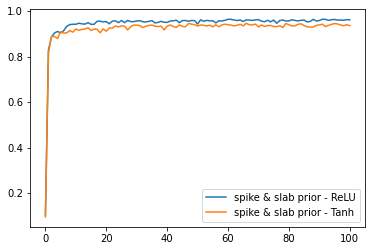

In [25]:
plt.plot(model1.History_learning, label = 'spike & slab prior - ReLU')
plt.plot(model2.History_learning, label = 'spike & slab prior - Tanh')
plt.legend()
plt.show()

In [26]:
from numpy import savetxt

In [27]:
np.savetxt('result1.txt', 1-np.array(model1.History_learning), fmt='%s', delimiter=",")
np.savetxt('result2.txt', 1-np.array(model2.History_learning), fmt='%s', delimiter=",")